---
<h1 style="text-align: center;">IF867 - Introdução à Aprendizagem Profunda</h1>
<h2 style="text-align: center;">2ª atividade prática</h2>

---
---
*Discente:*

* Gabriel D'assumpção de Carvalho - gdc2@cin.ufpe.br

*Curso:*

* Ciências Atuariais - 7º Período

<div style="text-align: center;">
26/02/2024
</div>

# Introdução

O objetivo desta atividade é desenvolver um modelo próprio de rede neural convolucional (CNN), denominado ResuraNet, e aplicá-lo ao conjunto de dados MNIST. O processo começa com uma análise exploratória dos dados, seguida pela aplicação de técnicas de data augmentation e transformação dos dados. Após essas etapas, o modelo desenvolvido será comparado com uma versão do ResNet18 que utiliza fine-tuning. O objetivo final é avaliar a performance do modelo proposto em relação ao modelo pré-existente.

# Importações

## Bibliotecas

In [65]:
# Gerenciamento do Sistema e do PyTorch
import os
import torch

# Manipulação de Dados e Visualização
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import models
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import cv2
from torchvision import datasets, transforms


# Construção do Modelo (Camadas e Funções do PyTorch)
from torch import flatten
from torch.nn import (
    Module,
    Conv2d,
    MaxPool2d,
    Linear,
    ReLU,
    LogSoftmax,
    NLLLoss,
    Flatten,
    Dropout,
)
import torch.nn.functional as F

# Treinamento e Otimização
from torch.optim import Adam
import time

# Avaliação do Modelo
from sklearn.metrics import classification_report

# Definição do Dispositivo (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Verificar se CUDA (GPU) está disponível
if torch.cuda.is_available():
    print(f"CUDA está disponível. Usando GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA não está disponível. Usando CPU.")

# Definir semente para reprodutibilidade
torch.manual_seed(42)

CUDA está disponível. Usando GPU: NVIDIA GeForce GTX 1050


## Datasets - MNIST

In [3]:
# Load MNIST dataset
def load_MNIST():
    current_dir = os.getcwd()
    data_path = os.path.join(current_dir, "data")

    train = MNIST(root=data_path, train=True, transform=ToTensor(), download=False)
    test = MNIST(
        root=data_path,
        train=False,
        transform=ToTensor(),
        download=False,
    )
    train.data = train.data.float()
    test.data = test.data.float()

    return train, test

train, test = load_MNIST()

# Analise exploratória dos dados

Nessa sessão vai ser elaborado funções para fazer um breve tratamento no banco de dados para facilitar o aprendizado da rede.

In [4]:
def check_missing_values(dataset):
    missing_values = (dataset.data.isnan().sum(), dataset.targets.isnan().sum())
    print(f"Missing values - Data: {missing_values[0]}, Targets: {missing_values[1]}")


def check_duplicates(dataset):
    unique_data = torch.unique(dataset.data.view(dataset.data.size(0), -1), dim=0)
    duplicates = dataset.data.size(0) - unique_data.size(0)
    print(f"Duplicate samples found: {duplicates}")


# Normalize data to [0, 1]
def normalizeMinMax(train, test):

    # Get min and max
    min = train.data.min()
    max = train.data.max()

    # Normalize
    train.data.sub_(min).div_(max - min)
    test.data.sub_(min).div_(max - min)

    return train, test


# Normalize data to z-score
def normalizeZScore(train, test):

    # Get mean ad standard deviation
    mean = train.data.mean()
    std = train.data.std()

    # Normalize
    train.data.sub_(mean).div_(std)
    test.data.sub_(mean).div_(std)

    return train, test


def gauss_noise_tensor(train, n, max_sigma=0.1):
    assert isinstance(train.data, torch.Tensor)

    # Seleciona n índices aleatórios
    indices = torch.randint(0, len(train.data), (n,))

    # Gera o ruído
    min = 0.1
    sigma = torch.rand(n) * max_sigma
    sigma = torch.clamp(sigma, min, max_sigma)

    noise = torch.randn_like(train.data[indices]) * sigma.view(-1, 1, 1)

    # Gera os dados sintéticos
    syntheticData = train.data[indices] + noise
    syntheticTarget = train.targets[indices]

    # Concatenar os dados sintéticos com os dados originais
    train.data = torch.cat((train.data, syntheticData), 0)
    train.targets = torch.cat((train.targets, syntheticTarget), 0)

    return train, syntheticData, indices  # Retorna os dados sintéticos e os índices


def validationSplit(train, percent=0.1):
    # Calcula o tamanho do conjunto de validação
    val_size = int(len(train) * percent)
    train_size = len(train) - val_size

    # Divide o dataset
    train_dataset, val_dataset = random_split(train, [train_size, val_size])

    return train_dataset, val_dataset

## Shape Imagens

In [5]:
# Selecionando uma amostra aleatória de imagens e verificando suas dimensões
shapeZero = train.data[0].shape
shapeAll = all(image.shape == shapeZero for image in train.data)


print(f"Total Samples: {train.data.shape[0]}")
if shapeAll:
  print(f"The all imagens have equal shape: {shapeZero}")
else:
  print(f'The imagens does not have equal shape')

Total Samples: 60000
The all imagens have equal shape: torch.Size([28, 28])


No código acima, podemos observar que todas as imagens do conjunto de treinamento possuem as mesmas dimensões, com 60.000 observações. As imagens são em escala de cinza, possuindo apenas um canal de cor, e têm dimensões de 28x28 pixels. Portanto, será necessário configurar o canal de entrada da primeira camada da CNN como 1.

## Dados Duplicidades

In [6]:
print(check_duplicates(train), check_missing_values(train))

Duplicate samples found: 0
Missing values - Data: 0, Targets: 0
None None


Como pode ser observado acima, nosso conjunto de dados de treinamento não contém dados duplicados ou ausentes. Com isso, podemos seguir para as transformações das variáveis.

## Data Transformation e Data Augmentation

Primeiramente, vamos aplicar a transformaçõe Min-Max para normalizar os dados de treinamento. Vale ressaltar que os dados de teste não serão analisados até o momento da inferência, a fim de evitar qualquer viés no nosso modelo.

In [7]:
trainMinMax, testMinMax = load_MNIST()

trainMinMax, testMinMax = normalizeMinMax(trainMinMax, testMinMax)

Após a transformação, realizaremos o data augmentation para adicionar 2.500 imagens sintéticas ao nosso conjunto de dados de treinamento, introduzindo ruído gaussiano.

In [8]:
# Gerar dados sintéticos e capturar os índices
trainMinMax, syntheticGaussM, indicesM = gauss_noise_tensor(
    trainMinMax, n=2500, max_sigma=0.2
)


In [9]:
print(f"Total Samples (MinMax): {trainMinMax.data.shape[0]}")

Total Samples (MinMax): 62500


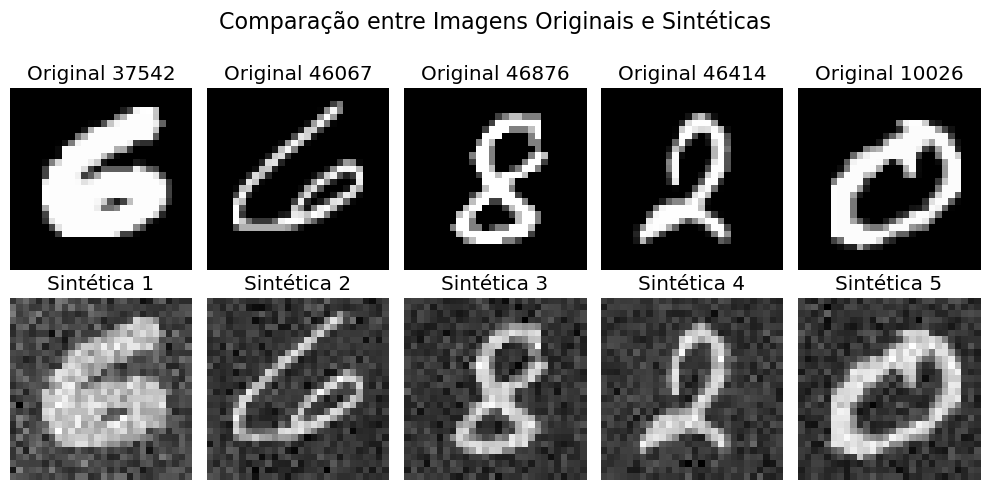

In [10]:
# Plotar as imagens originais e sintéticas
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Adicionar um título geral para a figura
fig.suptitle("Comparação entre Imagens Originais e Sintéticas\n", fontsize=16)

# Plotar as imagens originais
for i, idx in enumerate(indicesM[:5]):  # Limitar a 5 imagens
    ax = axes[0, i]
    ax.imshow(trainMinMax.data[idx].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Original {idx.item()}")

# Plotar as imagens sintéticas
for i in range(5):
    ax = axes[1, i]
    ax.imshow(syntheticGaussM[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"\nSintética {i+1}")

plt.tight_layout()
plt.show()

No gráfico acima, é possível observar, na primeira linha, as imagens originais, enquanto na segunda linha estão as imagens sintéticas geradas com ruído gaussiano. O objetivo dessa técnica de data augmentation é aumentar a robustez do modelo durante a inferência, reduzindo assim o risco de overfitting. A seguir, comparamos o desempenho do treinamento da rede utilizando dados normalizados pela técnica Min-Max, a introdução do ruído gaussiano e o modelo RasuraNet proposto por nós, contrastando com o fine-tuning do modelo ResNet18.

## Validation Split

In [11]:
trainMinMax, valMinMax = validationSplit(trainMinMax, 0.2)

# Treinamento

In [12]:
# Definir hiperparâmetros de treinamento
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 15

## RasuraNet

In [13]:
class RasuraNet(Module):
    def __init__(self, numChannels, classes, dropout_rate=0.5):
        super(RasuraNet, self).__init__()

        # Convolutional layers
        self.conv1 = Conv2d(
            in_channels=numChannels, out_channels=20, kernel_size=(5, 5)
        )
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.flatten = Flatten()

        # Fully connected layers with dropout
        self.fc1 = Linear(in_features=4 * 4 * 50, out_features=500)
        self.relu3 = ReLU()
        self.dropout1 = Dropout(p=dropout_rate)  # Dropout após a primeira FC

        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)  # Aplica dropout antes da última camada

        x = self.fc2(x)
        output = self.logSoftmax(x)

        return output

O modelo proposto, RasuraNet, é uma rede neural convolucional (CNN) projetada para classificação de imagens. Ele é composto por camadas convolucionais, camadas totalmente conectadas (fully connected) e camadas de regularização com dropout. Abaixo estão os principais componentes do modelo:

1. **Camadas Convolucionais (Conv2d):**

* conv1: A primeira camada convolucional possui 20 filtros de tamanho 5x5 e é responsável por capturar características iniciais da imagem, como bordas e formas simples.
* conv2: A segunda camada convolucional, com 50 filtros de 5x5, amplia a capacidade do modelo de identificar padrões mais complexos nas imagens.

2. **Funções de Ativação (ReLU):**

* Após cada camada convolucional, é aplicada uma função de ativação ReLU (Rectified Linear Unit), que introduce não-linearidade no modelo, permitindo que ele aprenda representações mais complexas.

3. **Camadas de Pooling (MaxPool2d):**

* maxpool1 e maxpool2 são camadas de max pooling com tamanho de 2x2 e stride de 2, responsáveis por reduzir a resolução das imagens e manter as características mais importantes, ajudando a evitar overfitting e diminuindo o tempo de computação.

4. **Flatten:**

* Após as camadas convolucionais e de pooling, a saída é achatada em um vetor unidimensional para ser alimentada nas camadas totalmente conectadas.

5. **Camadas Totalmente Conectadas (Fully Connected - FC):**

* fc1: A primeira camada totalmente conectada possui 500 neurônios e é responsável por aprender representações mais abstratas dos dados processados pelas camadas convolucionais.
* fc2: A segunda camada totalmente conectada tem a quantidade de saídas igual ao número de classes, e a ativação LogSoftmax é aplicada para calcular as probabilidades das classes.

6. **Dropout:**

* O dropout1 é aplicado após a primeira camada totalmente conectada (fc1) com uma taxa de 50% (p=0.5). O objetivo do dropout é regularizar a rede, evitando overfitting, desligando aleatoriamente uma proporção dos neurônios durante o treinamento. Isso força o modelo a aprender representações mais robustas e generalizáveis.

Com esse design, RasuraNet é capaz de aprender tanto características locais simples (com as camadas convolucionais) quanto características mais complexas (com as camadas totalmente conectadas), enquanto o uso de dropout ajuda a melhorar a generalização do modelo.

In [14]:
# Definir os DataLoaders para treinamento e validação
trainMinMax = DataLoader(trainMinMax, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valMinMax = DataLoader(valMinMax, batch_size=BATCH_SIZE, shuffle=False)

# Calcular número de passos por época
trainSteps = len(trainMinMax)
valSteps = len(valMinMax)

# Inicializar modelo, otimizador e função de perda
print("[INFO] Inicializando a RasuraNet...")
modelRasuraNet = RasuraNet(1, 10, dropout_rate=0.2).to(device)
optMinMax = Adam(modelRasuraNet.parameters(), lr=INIT_LR)
lossCE = NLLLoss()

# Dicionário para armazenar histórico de treinamento
historyMinMax = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Medir tempo de treinamento
print("[INFO] Treinando a rede...")
startTime = time.time()

# Loop de treinamento
for e in range(EPOCHS):
    modelRasuraNet.train()
    totalTrainLoss = 0.0
    totalValLoss = 0.0
    trainCorrect = 0
    valCorrect = 0

    # Loop de treinamento
    for x, y in trainMinMax:
        x, y = x.to(device), y.to(device)

        # Forward e cálculo da perda
        pred = modelRasuraNet(x)
        loss = lossCE(pred, y)

        # Backpropagation
        optMinMax.zero_grad()
        loss.backward()
        optMinMax.step()

        # Atualização das métricas
        totalTrainLoss += loss.item()
        trainCorrect += (pred.argmax(1) == y).sum().item()

    # Avaliação no conjunto de validação (sem gradientes)
    modelRasuraNet.eval()
    with torch.no_grad():
        for x, y in valMinMax:
            x, y = x.to(device), y.to(device)
            pred = modelRasuraNet(x)
            loss = lossCE(pred, y)

            totalValLoss += loss.item()
            valCorrect += (pred.argmax(1) == y).sum().item()

    # Cálculo da perda e acurácia médias
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    trainAcc = trainCorrect / len(trainMinMax)
    valAcc = valCorrect / len(valMinMax)

    # Armazenar histórico
    historyMinMax["train_loss"].append(avgTrainLoss)
    historyMinMax["train_acc"].append(trainAcc)
    historyMinMax["val_loss"].append(avgValLoss)
    historyMinMax["val_acc"].append(valAcc)

    # Exibir informações de treinamento
    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train Loss: {avgTrainLoss:.6f}, Train Acc: {trainAcc:.4f}")
    print(f"Val Loss: {avgValLoss:.6f}, Val Acc: {valAcc:.4f}\n")

print(f"[INFO] Treinamento concluído em {time.time() - startTime:.2f} segundos")

torch.save(modelRasuraNet.state_dict(), "rasuranet.pth")

[INFO] Inicializando a RasuraNet...
[INFO] Treinando a rede...
[INFO] EPOCH: 1/15
Train Loss: 1.416899, Train Acc: 31.6164
Val Loss: 1.271449, Val Acc: 35.0969

[INFO] EPOCH: 2/15
Train Loss: 1.231122, Train Acc: 35.8414
Val Loss: 1.203269, Val Acc: 36.2908

[INFO] EPOCH: 3/15
Train Loss: 1.192016, Train Acc: 36.6253
Val Loss: 1.176880, Val Acc: 36.8980

[INFO] EPOCH: 4/15
Train Loss: 1.168686, Train Acc: 37.1893
Val Loss: 1.162981, Val Acc: 37.1939

[INFO] EPOCH: 5/15
Train Loss: 1.149463, Train Acc: 37.5102
Val Loss: 1.155590, Val Acc: 37.5153

[INFO] EPOCH: 6/15
Train Loss: 1.131584, Train Acc: 37.8235
Val Loss: 1.146177, Val Acc: 37.6582

[INFO] EPOCH: 7/15
Train Loss: 1.116880, Train Acc: 38.2148
Val Loss: 1.136247, Val Acc: 37.9439

[INFO] EPOCH: 8/15
Train Loss: 1.102651, Train Acc: 38.4322
Val Loss: 1.135635, Val Acc: 38.0102

[INFO] EPOCH: 9/15
Train Loss: 1.088769, Train Acc: 38.7928
Val Loss: 1.139959, Val Acc: 37.9337

[INFO] EPOCH: 10/15
Train Loss: 1.073219, Train Acc: 39

No treinamento acima podemos ver que o modelo RasuraNet demorou 95 Segundos para treinar o modelo com 15 épocas, nas proximas sessões vamos analizar o seu desempenho

## ResNet18

In [15]:
# Modificar a última camada para adicionar LogSoftmax na saída
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedResNet18, self).__init__()
        # Carregar o modelo ResNet18 pré-treinado
        self.model = models.resnet18(pretrained=True)

        # Congelar as camadas do modelo (exceto a última camada)
        for param in self.model.parameters():
            param.requires_grad = False

        # Modificar a primeira camada convolucional para aceitar 1 canal de entrada
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1,  # Altere para 1 canal
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False,
        )

        # Modificar a última camada (classificador)
        self.model.fc = Linear(
            self.model.fc.in_features, num_classes
        )  # num_classes = número de classes do seu problema

    def forward(self, x):
        # Passa pela ResNet
        x = self.model(x)
        # Aplica LogSoftmax
        return F.log_softmax(x, dim=1)

In [16]:
# Instanciar o modelo modificado
modelResnet = ModifiedResNet18(num_classes=10)
modelResnet = modelResnet.to(device)

# Definir a função de perda e o otimizador
loss_fn = NLLLoss()
optimizer = torch.optim.Adam(
    modelResnet.model.fc.parameters(), lr=INIT_LR
)  # Treinar somente a camada fc

# Dicionário para armazenar histórico de treinamento
historyResnet = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# Fine-tuning do modelo
for epoch in range(EPOCHS):
    modelResnet.train()  # Coloca o modelo em modo de treinamento
    total_loss = 0
    correct = 0
    total = 0

    # Treinamento
    for x, y in trainMinMax:
        x, y = x.to(device), y.to(device)

        # Forward pass
        pred = modelResnet(x)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Atualizar as métricas
        total_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    # Avaliação no conjunto de validação (sem gradientes)
    modelResnet.eval()  # Coloca o modelo em modo de avaliação
    totalValLoss = 0
    valCorrect = 0
    valTotal = 0

    with torch.no_grad():
        for x, y in valMinMax:
            x, y = x.to(device), y.to(device)
            pred = modelResnet(x)
            loss = loss_fn(pred, y)

            totalValLoss += loss.item()
            _, valPredicted = torch.max(pred.data, 1)
            valTotal += y.size(0)
            valCorrect += (valPredicted == y).sum().item()

    # Cálculo da perda e acurácia médias
    avgTrainLoss = total_loss / trainSteps
    avgValLoss = totalValLoss / valSteps
    trainAcc = correct / len(trainMinMax)
    valAcc = valCorrect / len(valMinMax)

    # Armazenar histórico
    historyResnet["train_loss"].append(avgTrainLoss)
    historyResnet["train_acc"].append(trainAcc)
    historyResnet["val_loss"].append(avgValLoss)
    historyResnet["val_acc"].append(valAcc)

    # Exibir informações de treinamento
    print(f"[INFO] EPOCH: {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avgTrainLoss:.6f}, Train Acc: {trainAcc:.4f}")
    print(f"Val Loss: {avgValLoss:.6f}, Val Acc: {valAcc:.4f}\n")

torch.save(modelResnet.state_dict(), "resnet18.pth")

/home/gabrieldadcarvalho/miniconda3/envs/ds/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gabrieldadcarvalho/miniconda3/envs/ds/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] EPOCH: 1/15
Train Loss: 1.669191, Train Acc: 27.0908
Val Loss: 1.539951, Val Acc: 30.2653

[INFO] EPOCH: 2/15
Train Loss: 1.568568, Train Acc: 29.0499
Val Loss: 1.524754, Val Acc: 30.3673

[INFO] EPOCH: 3/15
Train Loss: 1.551692, Train Acc: 29.4962
Val Loss: 1.532881, Val Acc: 30.7194

[INFO] EPOCH: 4/15
Train Loss: 1.541460, Train Acc: 29.7366
Val Loss: 1.526375, Val Acc: 30.2296

[INFO] EPOCH: 5/15
Train Loss: 1.542425, Train Acc: 29.7545
Val Loss: 1.516235, Val Acc: 30.8827

[INFO] EPOCH: 6/15
Train Loss: 1.539841, Train Acc: 29.7289
Val Loss: 1.514565, Val Acc: 28.4949

[INFO] EPOCH: 7/15
Train Loss: 1.545252, Train Acc: 29.6138
Val Loss: 1.519962, Val Acc: 28.5255

[INFO] EPOCH: 8/15
Train Loss: 1.536204, Train Acc: 29.9130
Val Loss: 1.504347, Val Acc: 31.0153

[INFO] EPOCH: 9/15
Train Loss: 1.541510, Train Acc: 29.6228
Val Loss: 1.497182, Val Acc: 31.0459

[INFO] EPOCH: 10/15
Train Loss: 1.534884, Train Acc: 29.7813
Val Loss: 1.504238, Val Acc: 30.6837

[INFO] EPOCH: 11/15

# Teste

### RasuraNet

In [17]:
print("[INFO] evaluating network...")
with torch.no_grad():
    modelRasuraNet.eval()
    preds = []
    for x, y in testMinMax:
        if len(x.shape) == 3:  # [batch_size, H, W]
            x = x.unsqueeze(1)  # Add channel dim: [batch_size, 1, H, W]
        x = x.to(device)
        pred = modelRasuraNet(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())
print(
    classification_report(
        testMinMax.targets.cpu().numpy(),
        np.array(preds),
        target_names=testMinMax.classes,
    )
)

[INFO] evaluating network...
              precision    recall  f1-score   support

    0 - zero       0.48      0.50      0.49       980
     1 - one       0.73      0.93      0.82      1135
     2 - two       0.63      0.45      0.53      1032
   3 - three       0.48      0.50      0.49      1010
    4 - four       0.77      0.67      0.72       982
    5 - five       0.67      0.42      0.52       892
     6 - six       0.90      0.91      0.90       958
   7 - seven       0.53      0.79      0.63      1028
   8 - eight       0.41      0.38      0.39       974
    9 - nine       0.60      0.55      0.58      1009

    accuracy                           0.62     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.62      0.61     10000



A avaliação do modelo RasuraNet indica uma acurácia geral de 62%, com variações significativas no desempenho entre as classes. O dígito 1 ("one") obteve o melhor desempenho, com 93% de recall e um f1-score de 0.82, indicando que o modelo reconhece bem essa classe. Em contraste, a classe 8 ("eight") apresentou o pior desempenho, com um f1-score de 0.39, sugerindo dificuldades na diferenciação desse dígito.

O modelo se sai relativamente bem em classes como 6 ("six"), com 90% de precisão e recall, e 4 ("four"), com f1-score de 0.72. No entanto, apresenta dificuldades em números como 2 ("two"), 5 ("five") e 8 ("eight"), que possuem f1-scores abaixo de 0.55, indicando que o modelo frequentemente os confunde com outras classes.

A média macro (0.61 de precisão, recall e f1-score) reflete esse desequilíbrio entre as classes. Melhorias podem ser alcançadas com técnicas como data augmentation, ajuste de hiperparâmetros, aum

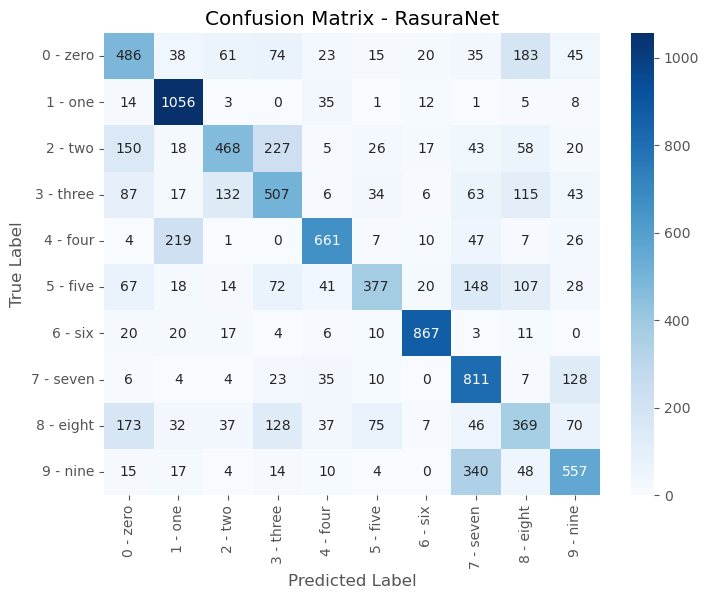

In [18]:
# Gerar a matriz de confusão
cm = confusion_matrix(testMinMax.targets.cpu().numpy(), np.array(preds))

# Criar o gráfico da matriz de confusão
plt.figure(figsize=(8, 6))  # Ajuste o tamanho conforme necessário
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=testMinMax.classes,
    yticklabels=testMinMax.classes,
)

# Adicionar rótulos
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RasuraNet")

plt.show()

A matriz de correlação reforça as observações anteriores sobre o desempenho do modelo RasuraNet. O modelo apresentou um alto índice de acertos na classe 1, possivelmente porque essa é a classe com o maior número de amostras (1135 observações), o que pode ter contribuído para um melhor aprendizado.

Por outro lado, o modelo frequentemente classifica erroneamente as observações da classe 9 como pertencentes à classe 7, sugerindo uma semelhança nos padrões identificados. Além disso, a classe 8, que apresenta o maior erro, é muitas vezes confundida com as classes 0 e 3, possivelmente devido à similaridade em seus formatos geométricos.

Diante desses desafios, é fundamental desenvolver um modelo mais profundo e robusto, capaz de capturar um maior número de características e minimizar essas confusões.

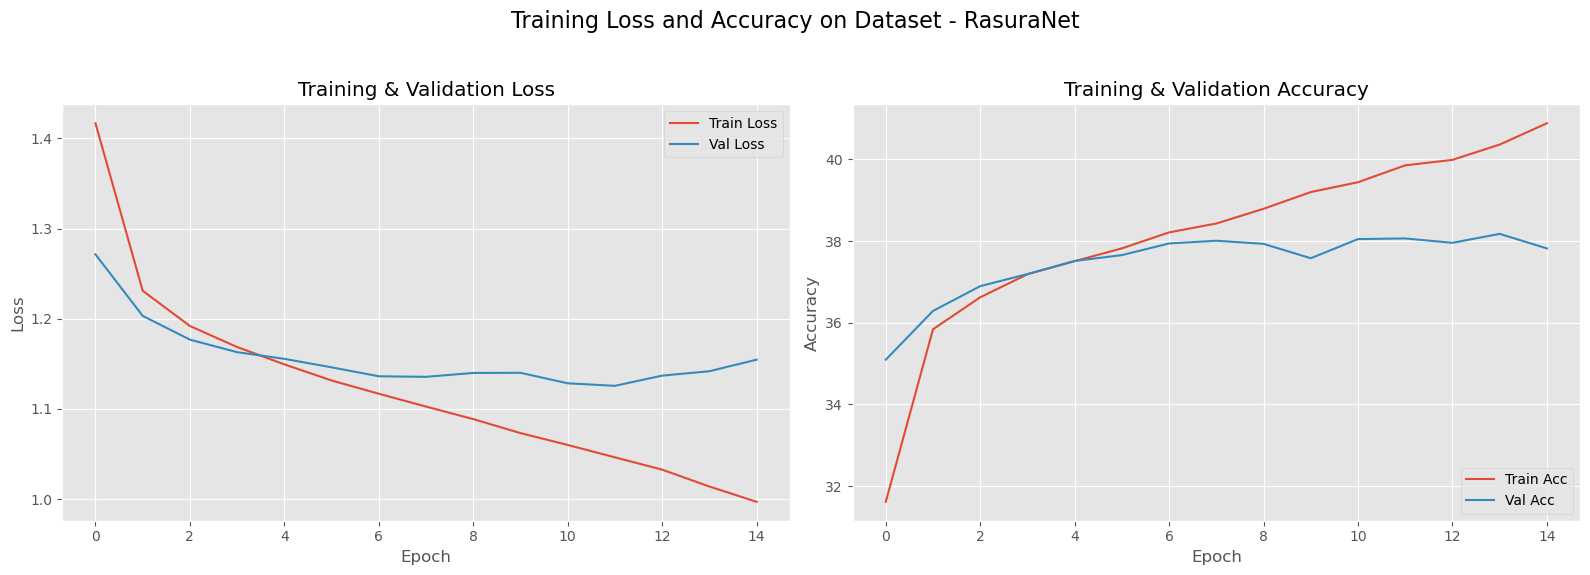

In [19]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6)
)  # 16x6 para dois gráficos lado a lado

# Gráfico de Perda
ax1.plot(historyMinMax["train_loss"], label="Train Loss")
ax1.plot(historyMinMax["val_loss"], label="Val Loss")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Gráfico de Acurácia
ax2.plot(historyMinMax["train_acc"], label="Train Acc")
ax2.plot(historyMinMax["val_acc"], label="Val Acc")
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

plt.suptitle("Training Loss and Accuracy on Dataset - RasuraNet", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

No gráfico acima, podemos observar que a loss de treinamento continua diminuindo ao longo das épocas, enquanto a loss de validação apresenta momentos de estabilização em alguns pontos. Já a acurácia de treinamento mantém um crescimento constante, enquanto a de validação apresenta algumas flutuações, mas com uma tendência geral de aumento.

Diante desse comportamento, uma possível melhoria para o modelo seria aumentar o número de épocas, permitindo um aprendizado mais refinado e potencialmente reduzindo a discrepância entre o desempenho em treinamento e validação.

### ResNet18

In [20]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
    # set the model in evaluation mode
    modelResnet.eval()

    # initialize a list to store our predictions
    preds = []
    # loop over the test set
    for x, y in testMinMax:
        if len(x.shape) == 3:  # [batch_size, H, W]
            x = x.unsqueeze(1)  # Add channel dim: [batch_size, 1, H, W]
        # send the input to the device
        x = x.to(device)
        # make the predictions and add them to the list
        pred = modelResnet(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(
    classification_report(
        testMinMax.targets.cpu().numpy(),
        np.array(preds),
        target_names=testMinMax.classes,
    )
)

[INFO] evaluating network...
              precision    recall  f1-score   support

    0 - zero       0.38      0.28      0.32       980
     1 - one       0.73      0.70      0.72      1135
     2 - two       0.52      0.33      0.40      1032
   3 - three       0.36      0.50      0.42      1010
    4 - four       0.53      0.59      0.56       982
    5 - five       0.38      0.30      0.34       892
     6 - six       0.79      0.78      0.79       958
   7 - seven       0.53      0.70      0.60      1028
   8 - eight       0.35      0.32      0.34       974
    9 - nine       0.50      0.54      0.52      1009

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



O modelo ResNet18 com Fine-Tuning apresentou uma acurácia de 51%, o que indica uma melhora modesta em relação a um classificador aleatório, mas ainda distante do ideal. Observamos um desempenho variável entre as classes, com a melhor performance na classe 6 (f1-score de 0.79) e a pior na classe 0 (f1-score de 0.32).

Além disso, o modelo teve dificuldades em distinguir corretamente algumas classes, especialmente 2, 5 e 8, que apresentam f1-scores baixos. Isso pode indicar que o modelo não capturou bem as características distintivas dessas classes ou que há uma sobreposição significativa entre elas.

Para melhorar o desempenho, seria interessante:

1. Ajustar hiperparâmetros, como a taxa de aprendizado e o número de épocas.
2. Aumentar os dados de treinamento (Data Augmentation) para reduzir o viés em classes específicas.
3; Explorar camadas mais profundas da ResNet18 durante o Fine-Tuning, permitindo que mais parâmetros sejam ajustados.

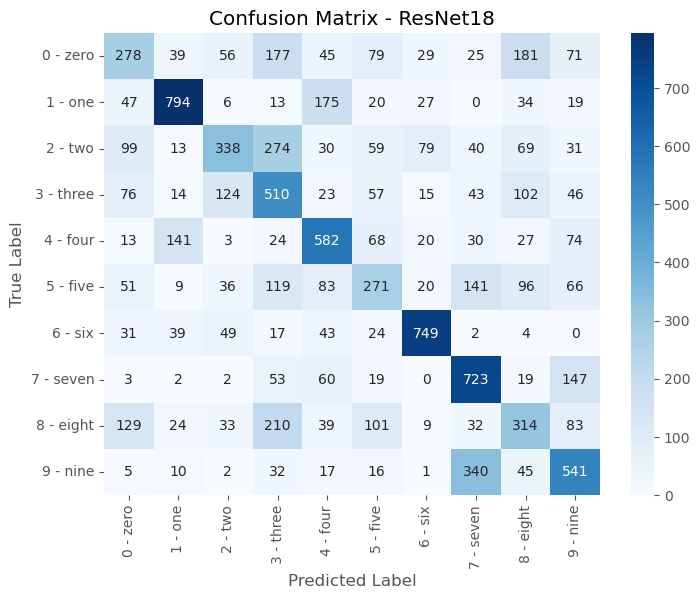

In [30]:
# Gerar a matriz de confusão
cm = confusion_matrix(testMinMax.targets.cpu().numpy(), np.array(preds))

# Criar o gráfico da matriz de confusão
plt.figure(figsize=(8, 6))  # Ajuste o tamanho conforme necessário
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=testMinMax.classes,
    yticklabels=testMinMax.classes,
)

# Adicionar rótulos
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet18")

plt.show()

Na matriz de confusão acima, podemos observar que o modelo continua confundindo a classe 8 com as classes 0 e 3, mesmo após o uso do modelo ResNet18. Isso indica que 15 épocas podem ser insuficientes para o modelo aprender os padrões específicos dos números manuscritos de maneira eficaz. Além disso, a classe 2 ainda é frequentemente confundida com a classe 3, comportamento semelhante ao observado no modelo RasuraNet. Esses resultados sugerem que o modelo pode se beneficiar de um maior número de épocas de treinamento ou de ajustes adicionais na arquitetura e nos dados de entrada.

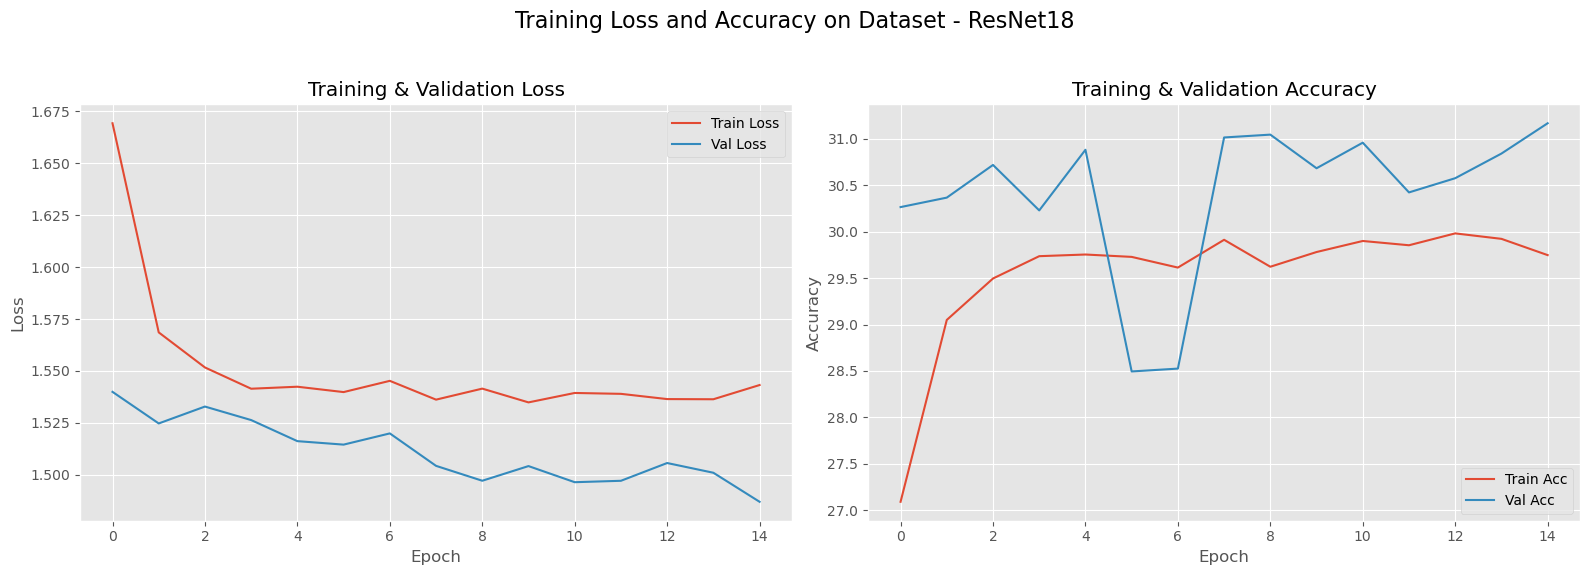

In [21]:
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6)
)  # 16x6 para dois gráficos lado a lado

# Gráfico de Perda
ax1.plot(historyResnet["train_loss"], label="Train Loss")
ax1.plot(historyResnet["val_loss"], label="Val Loss")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Gráfico de Acurácia
ax2.plot(historyResnet["train_acc"], label="Train Acc")
ax2.plot(historyResnet["val_acc"], label="Val Acc")
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

plt.suptitle("Training Loss and Accuracy on Dataset - ResNet18", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

No gráfico acima, podemos observar um comportamento peculiar: a loss de validação se manteve consistentemente menor do que a loss de treino durante todas as épocas. Além disso, a acurácia de validação também foi superior à de treinamento, embora tenha apresentado uma queda brusca nas épocas 5 e 6. Esse fenômeno pode sugerir que o modelo está se ajustando bem aos dados de validação. Para melhorar, seria interessante investigar mais a fundo o comportamento do modelo nessas épocas e considerar ajustes como regularização ou aumento de dados.


# Explicação Visual

In [67]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, class_idx=None):
        self.model.eval()
        input_image = input_image.unsqueeze(0)
        input_image.requires_grad = True

        output = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations not captured.")

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.relu(cam)

        if cam.max() > 0:
            cam = cam - cam.min()
            cam = cam / cam.max()

        return cam.detach().cpu().numpy()


def plot_gradcam_per_class(model, target_layer, test_dataset):
    # Collect one image per class (0-9)
    class_images = {}
    for image, label in test_dataset:
        if label not in class_images:  # Take the first occurrence of each class
            class_images[label] = image
        if len(class_images) == 10:  # Stop once we have all classes
            break

    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Grad-CAM Heatmaps for Classes 0-9", fontsize=16)

    gradcam = GradCAM(model, target_layer)

    for class_idx in range(10):
        # Get the image and move it to device
        image = class_images[class_idx].to(device)

        # Generate Grad-CAM heatmap for the true class
        heatmap = gradcam.generate(image, class_idx=class_idx)
        heatmap = cv2.resize(heatmap, (28, 28))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Prepare original image
        img = image.squeeze().cpu().numpy()
        img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-8))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Overlay heatmap on original image
        superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

        # Plot in the appropriate subplot
        row = class_idx // 5
        col = class_idx % 5
        axes[row, col].imshow(superimposed_img)
        axes[row, col].set_title(f"Class {class_idx}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

## RasuraNet

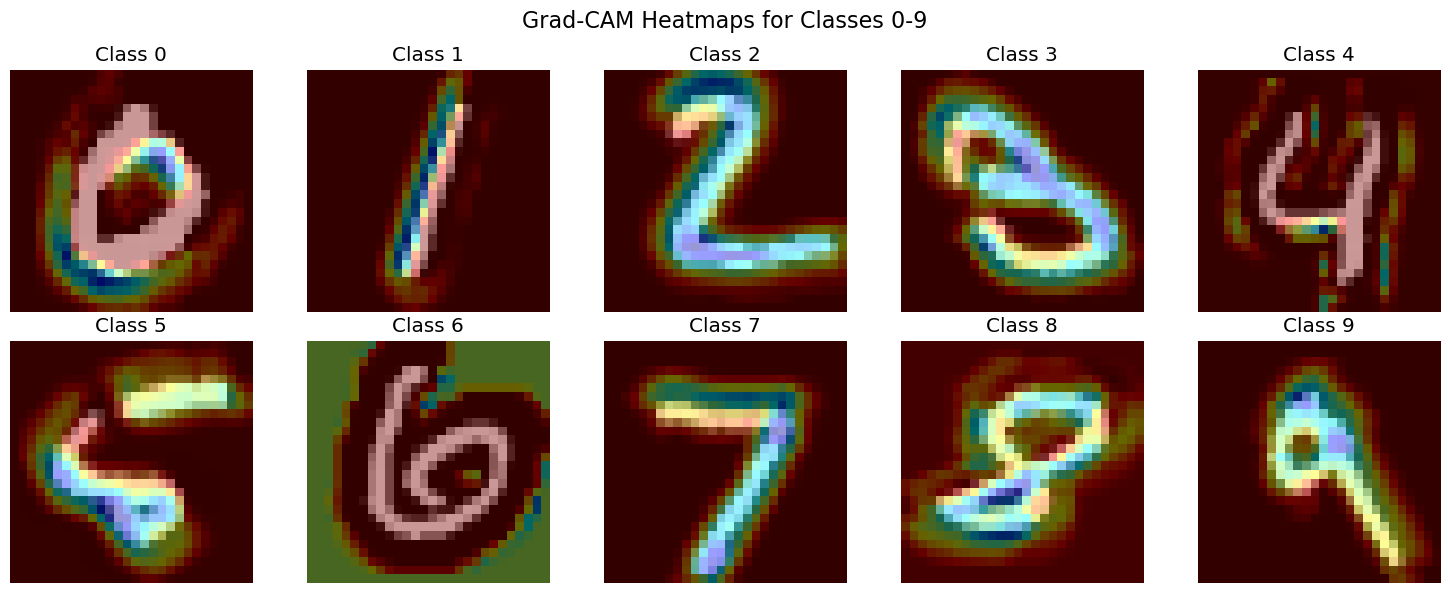

In [72]:
# Load model
model = RasuraNet(numChannels=1, classes=10).to(device)
model.load_state_dict(torch.load("rasuranet.pth"))  # Replace with your model path
model.eval()

# Select target layer
target_layer = model.conv1

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

# Generate and plot Grad-CAM for one image per class
plot_gradcam_per_class(model, target_layer, test_dataset)

Na imagem acima, podemos observar os mapas de calor Grad-CAM gerados para todas as classes do modelo RasuraNet. A análise revela que a classe 0 apresenta os pesos de gradiente mais dispersos, o que reflete um maior número de erros de classificação para essa classe. Para as demais classes, é possível perceber que os pesos de gradiente formam padrões mais organizados, geralmente delineando contornos. Isso sugere que a primeira camada convolucional do modelo está focada na detecção de características de contorno nas imagens, o que é uma evidência da capacidade do modelo em identificar estruturas geométricas importantes.

## ResNet18

/home/gabrieldadcarvalho/miniconda3/envs/ds/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gabrieldadcarvalho/miniconda3/envs/ds/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


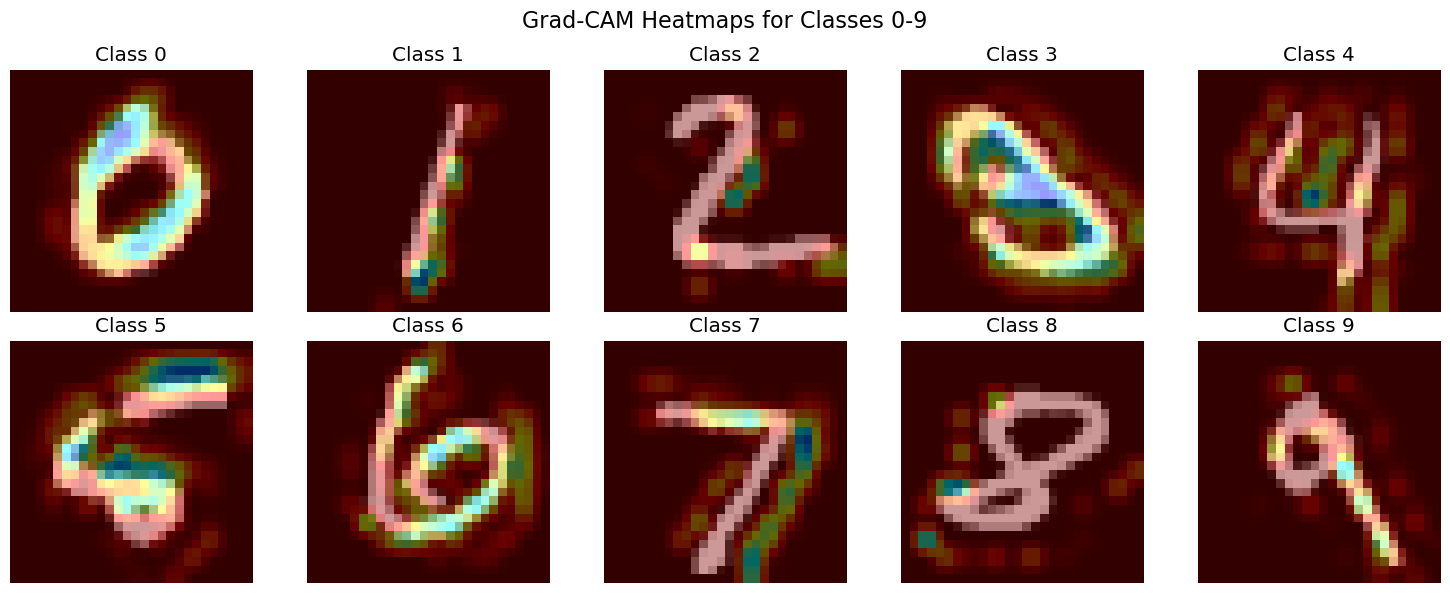

In [74]:
# Load model
model = ModifiedResNet18(10).to(device)
model.load_state_dict(torch.load("resnet18.pth"))  # Replace with your model path
model.eval()

# Select target layer
target_layer = model.model.conv1

# Load MNIST test dataset
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

# Generate and plot Grad-CAM for one image per class
plot_gradcam_per_class(model, target_layer, test_dataset)

No gráfico acima, ao analisarmos o Grad-CAM do modelo ResNet18, podemos observar que ele não apresenta filtros eficazes para detecção de contornos, apesar de tentar formar contornos nas imagens. Isso ocorre porque a convergência esperada não foi alcançada, já que o treinamento foi realizado com apenas a última camada descongelada. Portanto, podemos concluir que é crucial treinar o modelo com a última camada descongelada, e possivelmente também as primeiras camadas, para melhorar a capacidade de aprendizado das características visuais importantes.